# Clustering methods
The purpose of this notebook is to understand and implement two popular unsupervised learning methods to cluster data points. 

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

We generate data with the previously used `make_blobs` function. Although clustering methods are commonly used in unsupervised learning settings where no label *y* is available, we generate here one for a comparison later. 

The number of dimensions can be specified by `n_features` in the function below. To simplify our setting, we will only consider data points in 2-dimensional space but these methods can also be used in higher dimensions and you are encouraged to try out these scenarios.

In [15]:
# generate data
X, y = make_blobs(n_samples=200, n_features=2, centers=6, random_state=26, center_box=(0, 20))

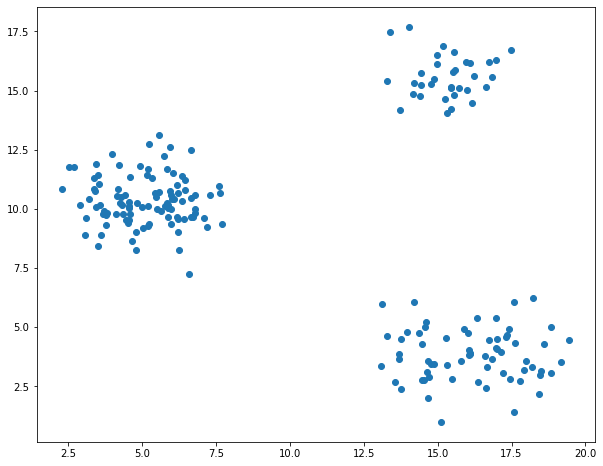

In [16]:
# visualising the clusters
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1]);

## $k$-means clustering

Let us start with randomly assigning the "labels" such that a given group of data points belong to one cluster, and computing the centroids of these clusters. We set $k$=4 for the beginning but you should experience later more values by yourself.

In [22]:
## EDIT THIS CELL

n_samples, n_features = X.shape

# number of clusters k
k = 6

# labels: assign every sample to a cluster at random
np.random.seed(123)
labels = np.random.randint(low=0, high=k, size=n_samples)
X_labels = np.append(X, labels.reshape(-1,1), axis=1)

# computing the centroids of each of the k clusters
centroids = np.zeros((k, n_features))
for i in range(k):
  centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:-1]   ## <-- EDIT THIS LINE

In [23]:
# check
centroids

array([[10.90612414,  9.02442065],
       [10.10675042,  8.98217447],
       [ 9.7053582 ,  9.37061377],
       [11.62531118,  8.18943349],
       [10.65346929, 10.29744446],
       [ 9.45661352,  8.98027611]])

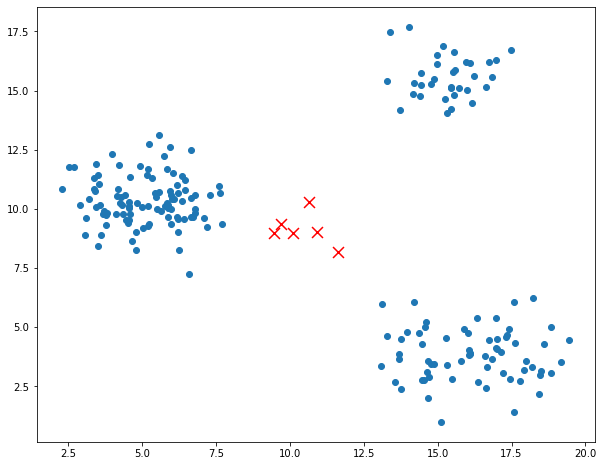

In [24]:
# plot centroids
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=120);

Now we iterate over any given number of iterations to relabel our data points to the closest centroid.

In [25]:
## EDIT THIS CELL

max_iter = 15
new_labels = np.zeros(len(X))
difference = 0

# k-means algorithm
for i in range(max_iter):
    print('Iteration:', i)
    # distances: between data points and centroids
    distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
    # new_labels: computed by finding centroid with minimal distance
    new_labels = np.argmin(distances, axis=0)

    if (labels==new_labels).all():
        # labels unchanged
        labels = new_labels
        print('Labels unchanged! Terminating k-means.')
        break
    else:
        # labels changed
        # difference: percentage of changed labels
        difference = np.mean(labels!=new_labels)    ## <-- EDIT THIS LINE
        print('%4f%% labels changed' % (difference * 100))
        labels = new_labels
        for c in range(k):
            # update centroids by taking the mean over associated data points
            if (labels == c).any():
              centroids[c] = np.mean(X[labels==c], axis=0)    ## <-- EDIT THIS LINE

Iteration: 0
78.000000% labels changed
Iteration: 1
6.000000% labels changed
Iteration: 2
10.000000% labels changed
Iteration: 3
7.500000% labels changed
Iteration: 4
3.000000% labels changed
Iteration: 5
2.500000% labels changed
Iteration: 6
1.500000% labels changed
Iteration: 7
Labels unchanged! Terminating k-means.


Now we can visualise the clusters in different colours to have a visual expression how well the $k$-means algorithm could separate the data.

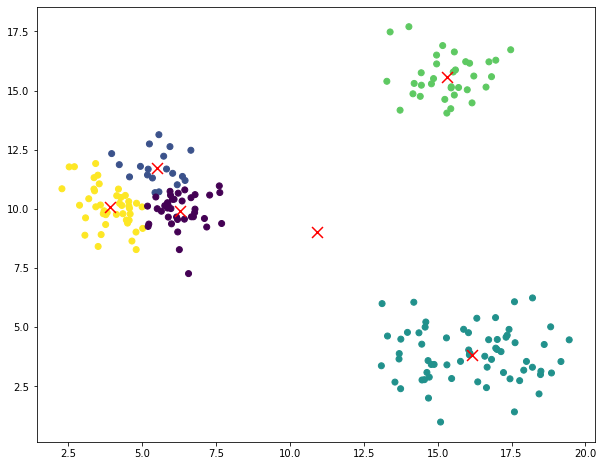

In [26]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c=labels);
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=120);

#### Questions
1. Change the value for $k$ and observe how this changes the clustering. 
2. Also change the value of the `random_state` or set it to `None` in the data-generating function. Is the $k$-means algorithm good in finding overlapping clusters?

## Hierarchical clustering

### Pairwise distances

Now let's define a function that returns a Numpy array storing the euclidean distances between every two points in `X`.

In [14]:
## EDIT THIS CELL

def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())    ## <-- EDIT THIS LINE
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

In [15]:
d = pairwise_distances(X)

### Linkage 

Implement the three linkage methods you know from the lecture material that can be considered for the hierarchical clustering.

In [16]:
## EDIT THIS CELL

def single_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the single linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The minimum distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the minimum
    return pairs_distance.min()    ## <-- EDIT THIS LINE


def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()    ## <-- EDIT THIS LINE

def complete_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the complete linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The maximum distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([ [element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the maximum
    return pairs_distance.max()    ## <-- EDIT THIS LINE

In [17]:
## EDIT THIS CELL

def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        if (level % 10) == 0:
          print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    ## <-- EDIT THIS LINE
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

In [18]:
a = hierarchical_clustering(X, d, single_linkage)

level:190
level:180
level:170
level:160
level:150
level:140
level:130
level:120
level:110
level:100
level:90
level:80
level:70
level:60
level:50
level:40
level:30
level:20
level:10


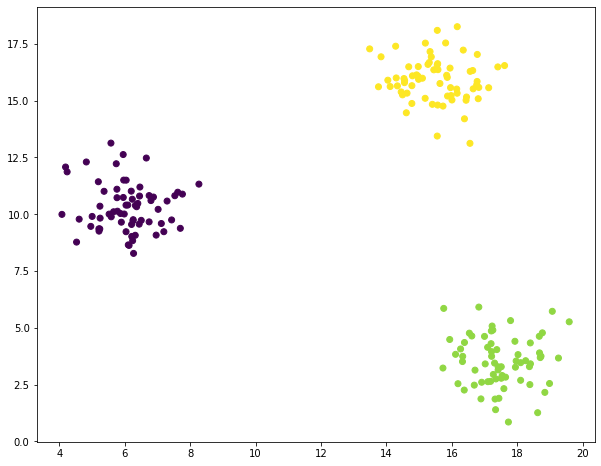

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c=a[3,:]);

#### Questions
1. What are the inherent advantages of hierarchical clustering over $k$-means? 
2. Try out different linkage methods. Can you observe any differences? If so, where do these differences come from?